A partir del dataset Multivariate_pollution.csv

In [411]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy import optimize
%matplotlib inline

In [412]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [413]:
def load_csv_dataset(dataset, modifyColumns, dropColumns):
    # Cargar el archivo CSV en un DataFrame de Pandas
    data = pd.read_csv(dataset, encoding='latin-1')

    # Modificar columnas según la lógica deseada
    columns = data.columns
    mappings = {}  # Diccionario para almacenar los mapeos

    for index in modifyColumns:
        name = columns[index]
        unique_values = list(data[name].unique())
        value_map = dict(zip(unique_values, [i for i in range(len(unique_values))]))
        data[name] = data[name].map(value_map)
        mappings[name] = value_map  # Almacenar el mapeo en el diccionario

    # Eliminar columnas no deseadas
    data = data.drop([columns[index] for index in dropColumns], axis=1)

    return data, mappings

data_pd, mappings = load_csv_dataset("/content/gdrive/MyDrive/SIS421/datasets/LSTM-Multivariate_pollution.csv", [i for i in range(0,8) if i in []], [0,1,2,4,5,6,7,8])

# Imprimir el mapeo de nombres de datos categóricos a valores numéricos
for column, mapping in mappings.items():
    print(f"Columna: {column}")
    print("Mapeo:")
    for key, value in mapping.items():
        print(f"{key} -> {value}")
    print()



In [414]:
print(data_pd)#nos quedamos solo con la columna temp

       temp
0      -4.0
1      -4.0
2      -5.0
3      -5.0
4      -5.0
...     ...
43795  -2.0
43796  -3.0
43797  -3.0
43798  -4.0
43799  -3.0

[43800 rows x 1 columns]


In [415]:
def preprocess_dataset(data):
    # Realizar operaciones adicionales en Pandas(para datos nan)

    # columnas_especificas = ['bmi']
    # media_columnas = data[columnas_especificas].mean()
    # data[columnas_especificas] = data[columnas_especificas].fillna(media_columnas)


    return data.to_numpy()
data= preprocess_dataset(data_pd)

In [416]:
data.shape

(43800, 1)

In [417]:
print(data)

[[-4.]
 [-4.]
 [-5.]
 ...
 [-3.]
 [-4.]
 [-3.]]


In [418]:

#normalizacion
data_min = np.min(data)
data_max = np.max(data)

data = (data - data_min) / (data_max - data_min)

In [419]:
def generate_time_series(data, n_steps, n_forecast=1):#se generara las series de tiempo
    X, y = [], []
    for i in range(len(data) - n_steps - n_forecast + 1):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps:i+n_steps+n_forecast])
    return np.array(X), np.array(y)

In [420]:
n_steps = 60  # 60 datos en cada serie temporal
n_forecast = 10  # predecir cuantos datos siguientes
X, y = generate_time_series(data, n_steps, n_forecast)

In [434]:
print(y.shape)

(43731, 10, 1)


In [422]:
# esta funcion genera series temporales sin taponerase unas a otras

# def generate_non_overlapping_series(data, n_steps, n_forecast=1):
#     X, y = [], []
#     for i in range(0, len(data) - n_steps - n_forecast + 1, n_steps):
#         X.append(data[i:i+n_steps])
#         y.append(data[i+n_steps:i+n_steps+n_forecast])
#     return np.array(X), np.array(y)

In [423]:
# n_steps = 60
# n_forecast = 10
# X, y = generate_non_overlapping_series(data, n_steps, n_forecast)

In [424]:
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)


In [425]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

In [426]:

train_size = int(0.7 * len(X))#70 % para entrenamietno
valid_size = int(0.2 * len(X))#20% para validacion, 10% restante para evaluacion

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test = X[train_size+valid_size:], y[train_size+valid_size:]

# Remodelación para garantizar que y tenga solo dos dimensiones
y_train = y_train.reshape(y_train.shape[0], -1)  # esto aplanaría la segunda dimensión
y_valid = y_valid.reshape(y_valid.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

print(X_train.shape, y_train.shape)

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}


(30611, 60, 1) (30611, 10)


In [427]:
# # 7009
# n_steps = 30
# X_train, y_train = X[:400, :n_steps], y[:400, -30:, 0]
# X_valid, y_valid = X[400:600, :n_steps], y[400:600, -30:, 0]
# X_test, y_test = X[600:, :n_steps], y[600:, -30:, 0]

# print(X_train.shape, y_train.shape)

# dataset = {
#     'train': TimeSeriesDataset(X_train, y_train),
#     'eval': TimeSeriesDataset(X_valid, y_valid),
#     'test': TimeSeriesDataset(X_test, y_test, train=False)
# }

# dataloader = {
#     'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
#     'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
#     'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
# }

In [428]:
X_test.shape, y_test.shape

((4374, 60, 1), (4374, 10))

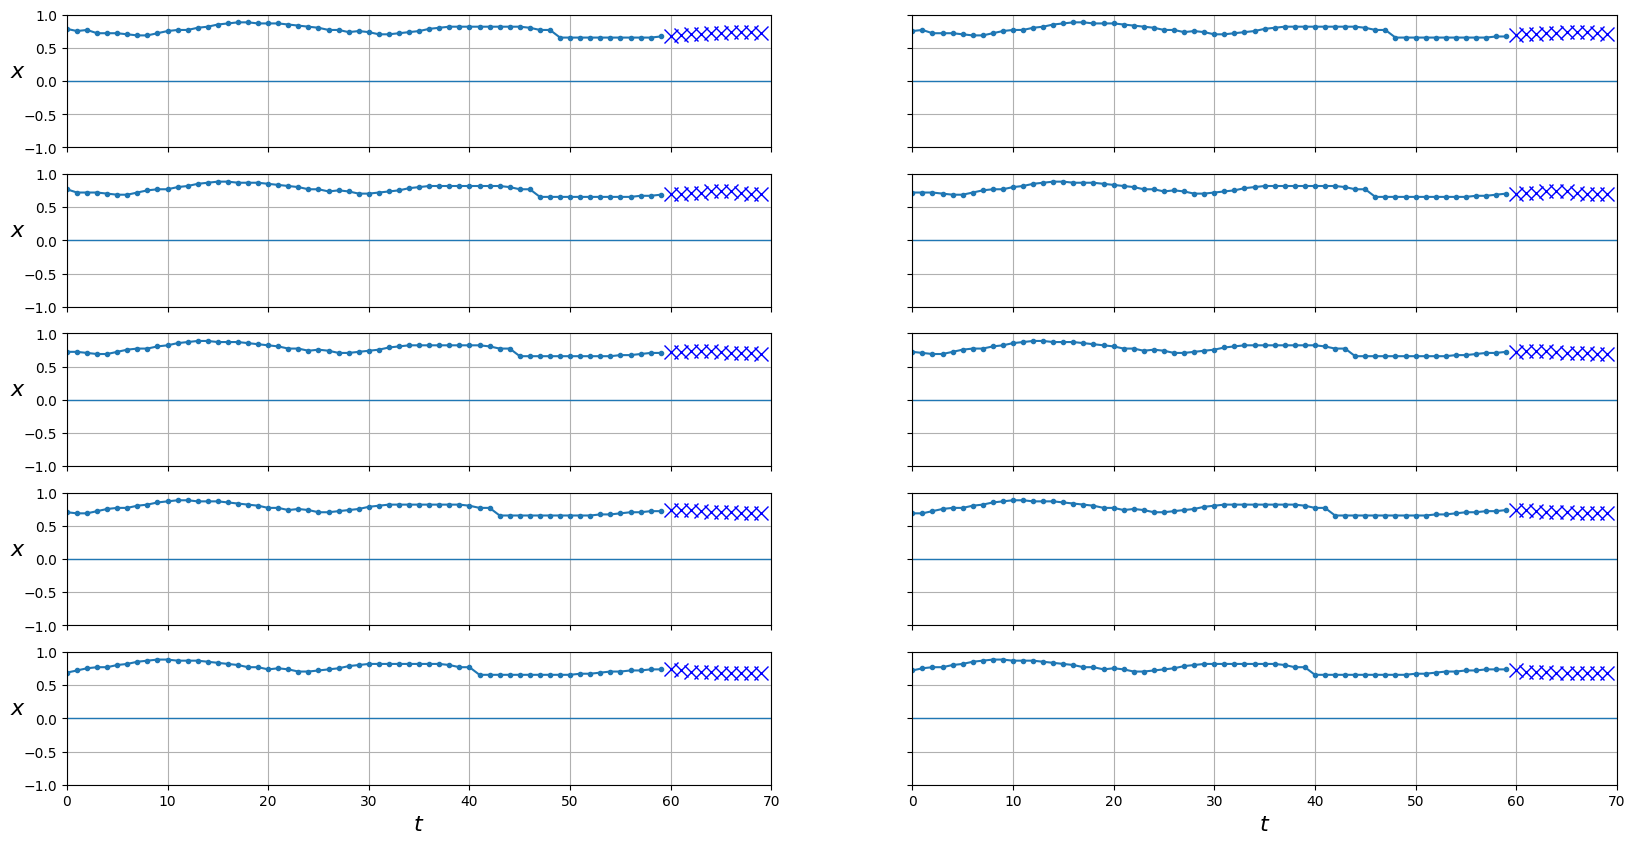

In [429]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 5, 2
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

In [430]:


class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    x = self.fc(x[:,-1])
    return x



In [431]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            # X, y = X.float().to(device), y.float().to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [432]:
rnn = DeepRNN()
fit(rnn, dataloader)

loss 0.00180 val_loss 0.00193: 100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


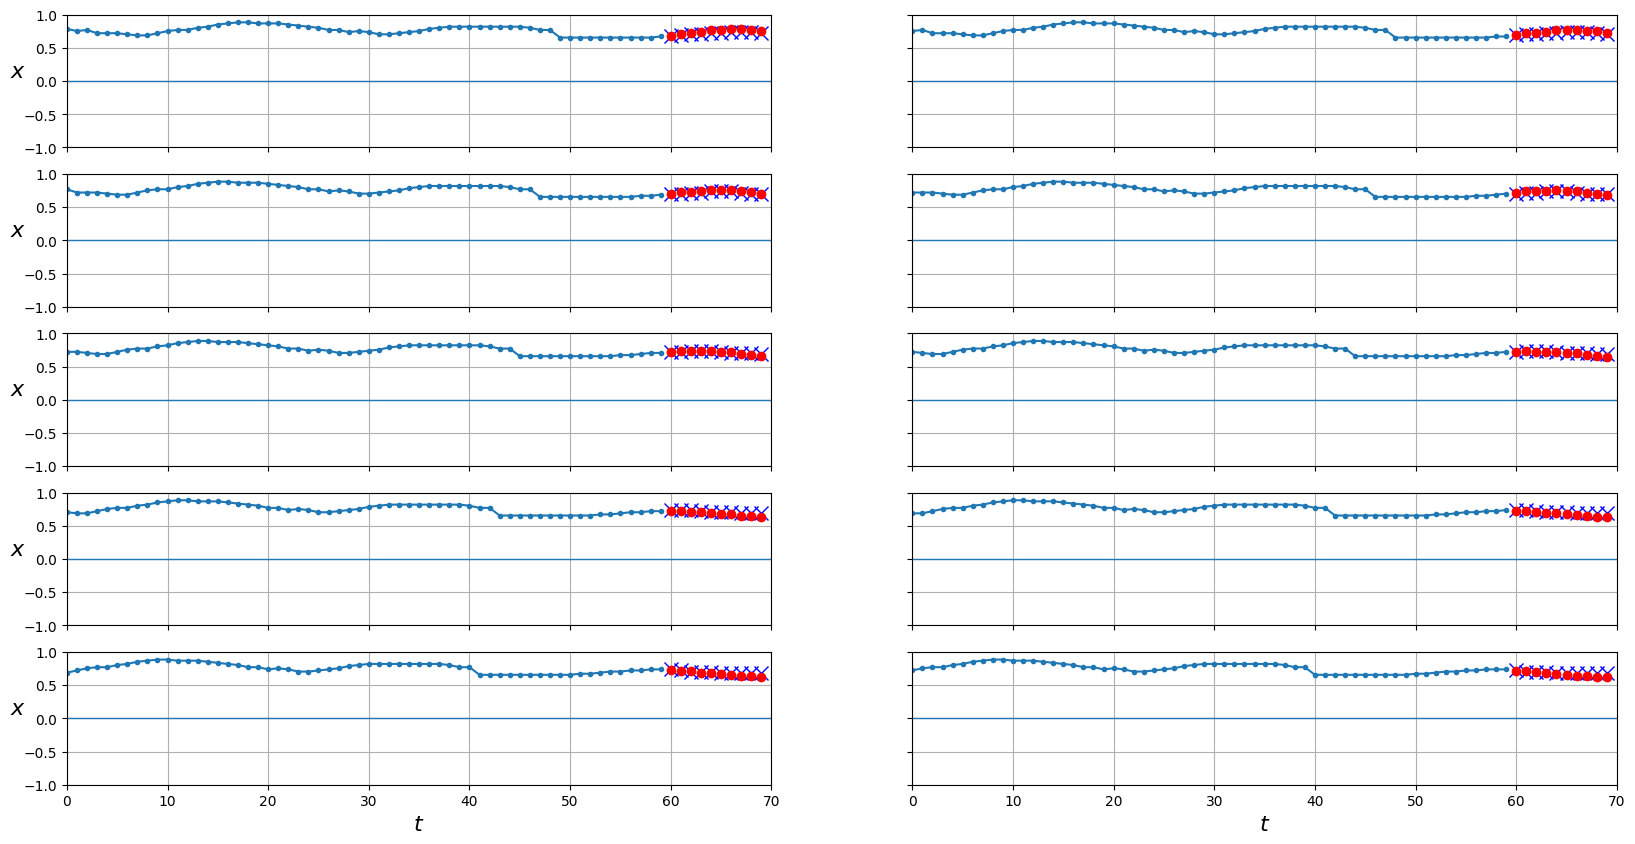

0.0017236304

In [433]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())